    Imports :

In [1]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from scipy.stats import norm

    1)

    1.a)

In [2]:
# uploading fetch_california_housing dataset from sklearn 
housing = fetch_california_housing()
print(housing.data.shape)

(20640, 8)


In [3]:
'''Function to compute the MSE '''
def MSE(y, y_pred):
    return np.mean((y - y_pred)**2)


'''Function to compute the R2 coeff'''
def R2(y, y_pred):
    return 1 - np.sum((y - y_pred)**2)/np.sum((y - np.mean(y))**2)

In [4]:
# Estimating the coefficients using the normal equation
X = np.c_[np.ones(housing.data.shape[0]), housing.data]
y = housing.target.reshape(-1, 1)

k = int(0.8*X.shape[0])
X_train = X[:k]
y_train = y[:k]
X_test = X[k:]
y_test = y[k:]

theta = np.linalg.inv(X_train.T @ X_train).dot(X_train.T).dot(y_train)

y_pred = X_test @ theta

In [5]:
# Computing the MSE and R2
print('MSE: ', MSE(y_test, y_pred))
print('R2: ', R2(y_test, y_pred))

MSE:  0.4946848356379541
R2:  0.6605140591537848


In [6]:
# Estimating the coefficients using the version of sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

# table to resume the results
print('For the test set:')
results = pd.DataFrame({'MSE': [MSE(y_test, y_pred), MSE(y_test, reg.predict(X_test))],'R2': [R2(y_test, y_pred), R2(y_test, reg.predict(X_test))]}, index=['Normal Equation', 'Sklearn'])
print(results)
print('------------------------------------------------')
print('For the train set:')
results = pd.DataFrame({'MSE': [MSE(y_train, X_train @ theta), MSE(y_train, reg.predict(X_train))],'R2': [R2(y_train, X_train @ theta), R2(y_train, reg.predict(X_train))]}, index=['Normal Equation', 'Sklearn'])
print(results)

For the test set:
                      MSE        R2
Normal Equation  0.494685  0.660514
Sklearn          0.494685  0.660514
------------------------------------------------
For the train set:
                      MSE        R2
Normal Equation  0.535534  0.584433
Sklearn          0.535534  0.584433


We can see that we have exactly the same values.

    1.b)

In [7]:
# Confidence intervals at level 99% for the coefficients
from scipy.stats import t

alpha = 0.01

n = X_train.shape[0]
p = X_train.shape[1]

sigma2 = np.sum((y_train - X_train @ theta)**2) / (n-p-1)
sigma = np.sqrt(sigma2)

s2 = np.linalg.inv(X_train.T @ X_train)
s = np.sqrt(s2)

t_stat = t.ppf(1-(alpha/2), n-p-1)

CI = [[] for i in range(p)]

for i in range(p):
    CI[i].append(theta[i] - t_stat * s[i, i] * sigma / np.sqrt(n))
    CI[i].append(theta[i] +  t_stat * s[i, i] * sigma / np.sqrt(n))

print('Confidence intervals at level 99% for the coefficients:')
# table to resume the results
results = pd.DataFrame({'Theta': theta.reshape(-1), 'CI': CI}, index=['Intercept'] + housing.feature_names)
print(results)


Confidence intervals at level 99% for the coefficients:
                Theta                                                 CI
Intercept  -36.390510       [[-36.40761850448574], [-36.37340200347904]]
MedInc       0.447847       [[0.4477508586508628], [0.4479433093509881]]
HouseAge     0.009408   [[0.009397894803841768], [0.009418519626738384]]
AveRooms    -0.120961    [[-0.1210936450997358], [-0.12082819261505426]]
AveBedrms    0.710268       [[0.7096376600232439], [0.7108979162420055]]
Population  -0.000001  [[-1.5757227876376993e-06], [-1.36534198122281...
AveOccup    -0.008815  [[-0.008837312593513507], [-0.0087926237989671...
Latitude    -0.421715    [[-0.42189721285747045], [-0.4215318045039432]]
Longitude   -0.429775    [[-0.4299706617084924], [-0.42957994064916494]]


C:\Users\user\AppData\Local\Temp\ipykernel_6424\3553225888.py:13: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(s2)


    2)

    2.a)

In [8]:
np.random.seed(0)

    2.b)

In [9]:
k = int(0.75*X.shape[0])
X_train = X[:k, 1:]
y_train = y[:k]
X_test = X[k:, 1:]
y_test = y[k:]

# standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

    2.c)

In [10]:
# Regular OLS
reg = LinearRegression().fit(X_train, y_train)

    3) Variable selection :

    3.a)

In [112]:
''' Function fiting p linear regression models each using only feature X_j'''
def fit_p_models(X, y):
    """
    X: matrix of features, reduced design matrix
    """
    p = X.shape[1]

    n = X.shape[0]
    # no intercept is used for this regression : the data set is centered
    reg = LinearRegression(fit_intercept = False)

    # test of the hypothesis H0: theta_j = 0
    t_stat = []
    p_values = []

    # fitting p linear regression models
    for i in range(p):
        reg = reg.fit(X[:, [i]], y)
        coeff = reg.coef_[0][0]

        X_i = X[:, [i]]
        # Gn_i = X_i.T @ X_i / n # This is one because we have standardized the data

        residuals =  y - reg.predict(X_i)

        # sigma2 = np.sum(residuals)**2 / (n-1)
        # sigma = np.sqrt(sigma2)

        # s = 1 / np.sqrt(Gn_i)
        print(residuals)
        sigma_x_snk_2 = ( np.sum(residuals)**2 / (n-1) )* n / np.sum(X_i**2)
        print(sigma_x_snk_2)

        t_ = np.abs(coeff) / np.sqrt(sigma_x_snk_2) 
        print(t_)
        t_stat.append(t_)
        p_values.append(2*(1 - t.cdf(t_, n-1)))

    print(p_values)
    return np.argmin(p_values), np.min(p_values), theta


S = []
p_values = []
while True:
    index, min_p_value, theta = fit_p_models(X_train, y_train)
    if min_p_value < 0.05:
        S += [index]
        p_values.append(min_p_value)
        X_train = np.delete(X_train, index, axis=1)
        y_train = y_train - X[:, index] * theta[index,index]
    else:
        break

print('The selected features are: ', S)  
print('The p-values are: ', p_values)

MemoryError: Unable to allocate 2.38 GiB for an array with shape (15480, 20640) and data type float64

    3.b) and 3.c)

In [83]:
S = []
p_values = []
while True:
    index, min_p_value, theta = fit_p_models(X_train, y_train)
    if min_p_value < 0.05:
        S += [index]
        p_values.append(min_p_value)
        X_train = np.delete(X_train, index, axis=1)
        y_train = y_train - X[:, index] * theta[index,index]
    else:
        break

print('The selected features are: ', S)  
print('The p-values are: ', p_values)


X_i [2.3923181]
Gn_i 0.0003697148495009071
s 52.00756887290133
sigma 0.7183092284185336
X_i [0.98785092]
Gn_i 6.30393693957579e-05
s 125.94881041462665
sigma 0.9980711549927594
X_i [0.5758368]
Gn_i 2.1420414822434373e-05
s 216.0658156818674
sigma 0.9889523520689872
X_i [-0.15062768]
Gn_i 1.4656782219158701e-06
s 826.0012082193358
sigma 0.9992767905861865
X_i [-0.95580634]
Gn_i 5.9015875483976896e-05
s 130.1713991590728
sigma 0.9997966305624291
X_i [-0.08837014]
Gn_i 5.044755710707615e-07
s 1407.9263261797275
sigma 0.9988446335061175
X_i [1.34639887]
Gn_i 0.00011710529201974974
s 92.4084613987713
sigma 0.9736013950498854
X_i [-1.76575079]
Gn_i 0.00020141316926231356
s 70.4621788471277
sigma 0.9966873956051489
[0.9851412640632946, 0.9996026919079899, 0.9994457034742616, 0.9999624324544201, 0.9998669113451546, 0.9999723572231265, 0.9979745807710858, 0.9990715588579449]
The selected features are:  []
The p-values are:  []


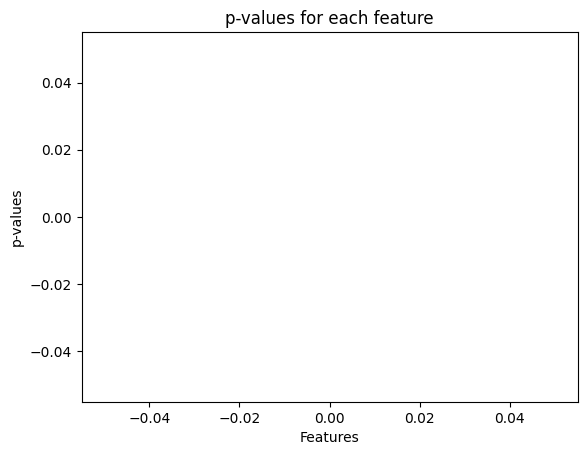

In [13]:
# plotting the first p-values
import matplotlib.pyplot as plt
plt.plot(p_values)
plt.xlabel('Features')
plt.ylabel('p-values')
plt.title('p-values for each feature')
plt.show()

The reason for subtracting the predictions or calculating the residuals to construct a new model, ...... 

    4) Extensions :

    4.a) and 4.b)

The grid of parameters is:  [1.00000000e-01 1.74332882e-01 3.03919538e-01 5.29831691e-01
 9.23670857e-01 1.61026203e+00 2.80721620e+00 4.89390092e+00
 8.53167852e+00 1.48735211e+01 2.59294380e+01 4.52035366e+01
 7.88046282e+01 1.37382380e+02 2.39502662e+02 4.17531894e+02
 7.27895384e+02 1.26896100e+03 2.21221629e+03 3.85662042e+03
 6.72335754e+03 1.17210230e+04 2.04335972e+04 3.56224789e+04
 6.21016942e+04 1.08263673e+05 1.88739182e+05 3.29034456e+05
 5.73615251e+05 1.00000000e+06]


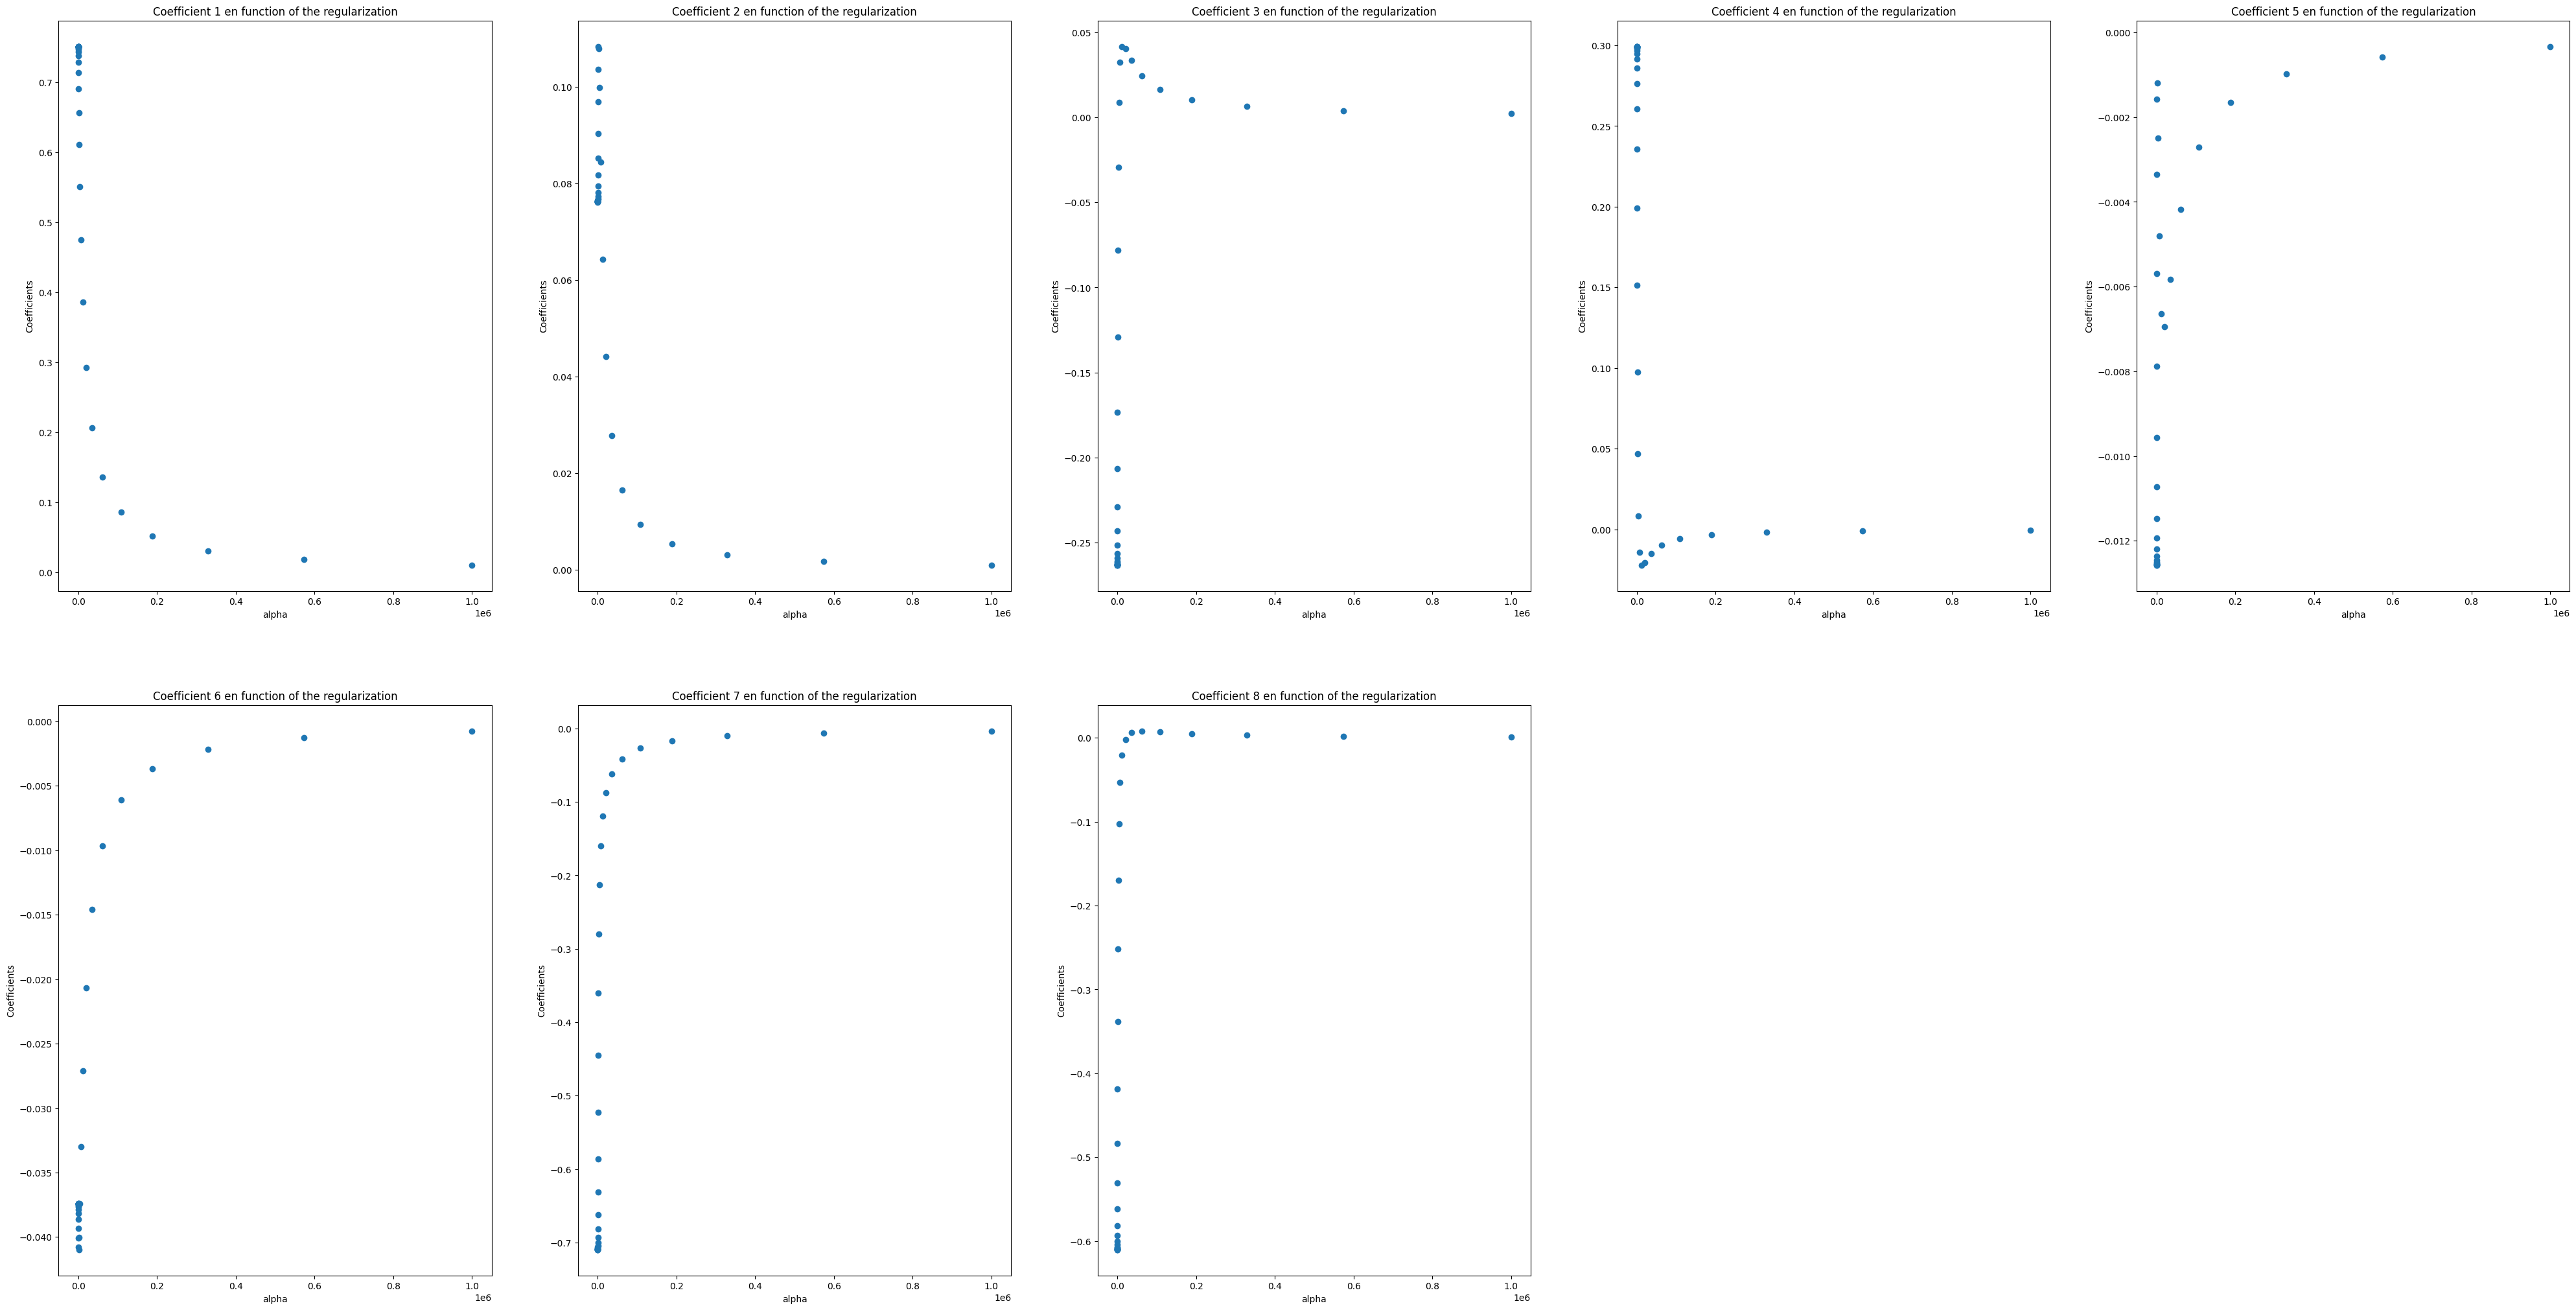

The best R2 is:  [0.5991105330175404, 0.5991044010967099, 0.5990937101281611, 0.599075069177388, 0.5990425625464455, 0.5989858646093074, 0.5988869365628346, 0.5987142185131455, 0.5984123637548926, 0.5978839613995419, 0.5969567466782927, 0.5953247182658439, 0.5924450260640588, 0.5873745221068503, 0.5785818884465845, 0.5639525087050148, 0.5414356212482951, 0.5103662309505479, 0.471923587514006, 0.4270495543954075, 0.37391145824256866, 0.3093329170021776, 0.2342747554070288, 0.15686358917382426, 0.08797208489814434, 0.034414773867699755, -0.003055868638795589, -0.02739464208383069, -0.042449714012156026, -0.0514813881324252]


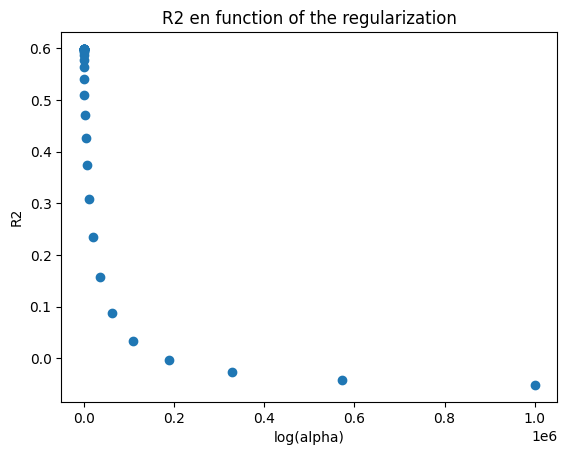

In [14]:
# Ridge regression using scikit-learn

def param_reg(X_train, y_train, model):
    # logaritmic scale
    param_grid = np.logspace(-1, 6, 30)

    print('The grid of parameters is: ', param_grid)
    # defining the model

    # defing the list of the coefficients
    coefs = []
    R2 = []
    for i in range(30):
        model.set_params(alpha=param_grid[i])
        model.fit(X_train, y_train)
        coefs.append(model.coef_)
        R2.append(model.score(X_test, y_test))

    coefs = np.array(coefs).reshape(30, 8)

    return param_grid, coefs, R2

ridge = Ridge()
param_grid, coefs, R2 = param_reg(X_train, y_train, ridge)
plt.figure(figsize=(50, 80))
for i in range(8):
    plt.subplot(6, 5, i+1)
    plt.scatter(param_grid, coefs[:,i])
    plt.xlabel('alpha')
    plt.ylabel('Coefficients')
    plt.title('Coefficient {} en function of the regularization'.format(i+1))
plt.show()

print('The best R2 is: ', R2)
# plotting the R2
plt.scatter(param_grid, R2)
plt.xlabel('log(alpha)')
plt.ylabel('R2')
plt.title('R2 en function of the regularization')
plt.show()